In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

In [3]:
# cross validation using statsmodel prepartion
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

In [4]:
# call data for hipotesis
data_model = joblib.load("D:/BOOTCAMP/project/(Block 4) Business Statistik/data_hipotesis.csv")
data_model.head(2)

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,254,Dini Hari,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,204,Dini Hari,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# Split data category
category_column = ['Functioning Day','Hour','Seasons', 'Holiday'] # column used
category_column

['Functioning Day', 'Hour', 'Seasons', 'Holiday']

In [6]:
# split data category
numeric_col = list(set(data_model.columns) - set(category_column))

In [7]:
def splitNumCat(data, num_col, cat_col):
    """"
    Function for split category between numeric
    data_num = input data split numeric
    data_cat = input data split category
    """
    data_num = data[num_col]
    data_cat = data[cat_col]

    return data_num, data_cat

In [8]:
# call function X_train
data_num, data_cat = splitNumCat(data = data_model,
                                       num_col = numeric_col,
                                       cat_col = category_column)

(data_num.shape),(data_cat.shape) 

((8760, 9), (8760, 4))

# OHE

In [9]:
# Encoder for model

# OHE from data_model
ohe_cat = pd.get_dummies(data_cat)

In [10]:
# concat data 
data_modeling = pd.concat([data_num, ohe_cat],
                           axis = 1)

(data_modeling.shape)

(8760, 21)

In [11]:
# rename columns
data_modeling.rename(columns={'Temperature(°C)': 'Temperature', 'Rented Bike Count' : 'Rented_Bike', 'Dew point temperature(°C)' : 'Dew_point_temp'}, inplace=True)

In [12]:
data_modeling.dtypes

Temperature                float64
Visibility (10m)             int64
Snowfall (cm)              float64
Rented_Bike                  int64
Humidity(%)                  int64
Wind speed (m/s)           float64
Rainfall(mm)               float64
Dew_point_temp             float64
Solar Radiation (MJ/m2)    float64
Functioning Day_No           uint8
Functioning Day_Yes          uint8
Hour_Dini Hari               uint8
Hour_Malam Hari              uint8
Hour_Pagi Hari               uint8
Hour_Siang Hari              uint8
Seasons_Autumn               uint8
Seasons_Spring               uint8
Seasons_Summer               uint8
Seasons_Winter               uint8
Holiday_Holiday              uint8
Holiday_No Holiday           uint8
dtype: object

#  Model Linier Regression 

we want check one predictor vs outcome that have high correlation
- Rented Bike Count	vs Temperature(°C) (0.54 correlation)

In [13]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from 
    :return df: <pandas DataFrame> 
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

In [14]:
# Create OLS model object
model = smf.ols("Rented_Bike ~ Temperature", data_modeling)

# Fit the model
results = model.fit()
y_pred_ = results.predict(data_modeling['Temperature'])

# Extract the results (Coefficient and Standard Error) to DataFrame
results_rent = print_coef_std_err(results)

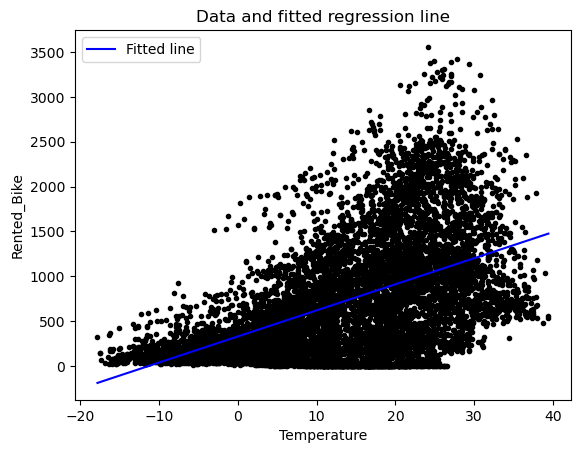

In [15]:
predictor = "Temperature"
outcome = "Rented_Bike"
data = data_modeling.copy()
results_ = results_rent.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), len(data))

fitted_values = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend()
plt.ylabel("Rented_Bike")
plt.xlabel("Temperature")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

In [16]:
results_rent

,coef,std err
Intercept,329.952514,8.541061
Temperature,29.081099,0.486173


$$\text{rent}= 329.952514 + 29.081099\text{(Temperature)} $$

- If Temperature is zero then rent bike is 329.952514, otherwise follow the value input that given from count temperature

### Residual - Single

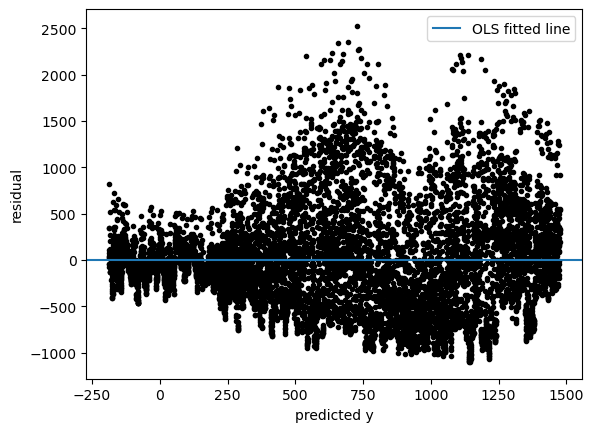

In [17]:
# plot the predicted values, and the residual
plt.scatter(fitted_values, results.resid, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="OLS fitted line")
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()

- Residual in the scatterplot a little inconsistent - have big spared between linier regression
- Now we will add weight so that this speared closer to linier regression  

In [18]:
# set the weight as 1 over squared (predictor column)
data_linier_single = data_modeling.copy()
weights = 1/(data_linier_single["Temperature"]**2)

In [19]:
data_linier_single["weights"] = weights
data_linier_single.head(2)

,Temperature,Visibility (10m),Snowfall (cm),Rented_Bike,Humidity(%),Wind speed (m/s),Rainfall(mm),Dew_point_temp,Solar Radiation (MJ/m2),Functioning Day_No,...,Hour_Malam Hari,Hour_Pagi Hari,Hour_Siang Hari,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,weights
0,-5.2,2000,0.0,254,37,2.2,0.0,-17.6,0.0,0,...,0,0,0,0,0,0,1,0,1,0.036982
1,-5.5,2000,0.0,204,38,0.8,0.0,-17.6,0.0,0,...,0,0,0,0,0,0,1,0,1,0.033058


In [20]:
# Create WLS (Weighted Least Square) model object and include the weight
model = smf.wls("Rented_Bike ~ Temperature", data_linier_single, weight = weights)

# Fit the model
results2 = model.fit()
y_pred = results2.predict(data_linier_single['Temperature'])

# Extract the results (Coefficient and Standard Error) to DataFrame
results_rent_weighted = print_coef_std_err(results2)

C:\Users\HP Notebook\anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['weight']
  warnings.warn(msg, ValueWarning)


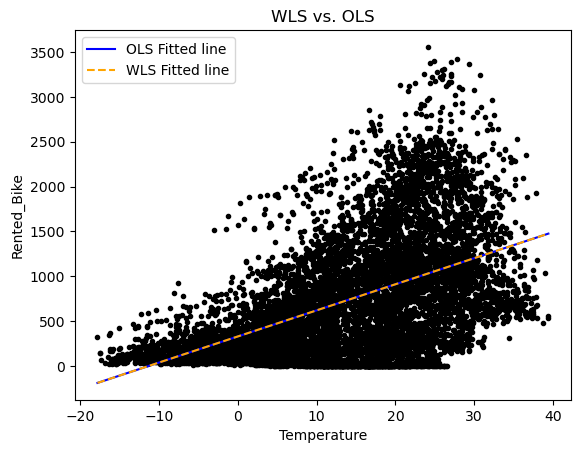

In [21]:
predictor = "Temperature"
outcome = "Rented_Bike"
data = data_linier_single.copy()
results_1 = results_rent.copy()
results_2 = results_rent_weighted.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat1 = results_1.loc["Intercept"]["coef"]
b_hat1 = results_1.loc[predictor]["coef"]

# Calculate the fitted values
a_hat2 = results_2.loc["Intercept"]["coef"]
b_hat2 = results_2.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), len(data))

fitted_values1 = a_hat1 + b_hat1 * x_domain
fitted_values2 = a_hat2 + b_hat2 * x_domain


# Plot the fitted line
plt.plot(x_domain, fitted_values1, label="OLS Fitted line", color = "b")

# Plot the fitted line
plt.plot(x_domain, fitted_values2, label="WLS Fitted line", color = "orange", linestyle = "--")

# Add a legend and labels
plt.legend()
plt.ylabel("Rented_Bike")
plt.xlabel("Temperature")

# Add a title and adjust the margins
plt.title("WLS vs. OLS")

# Show the plot
plt.show()

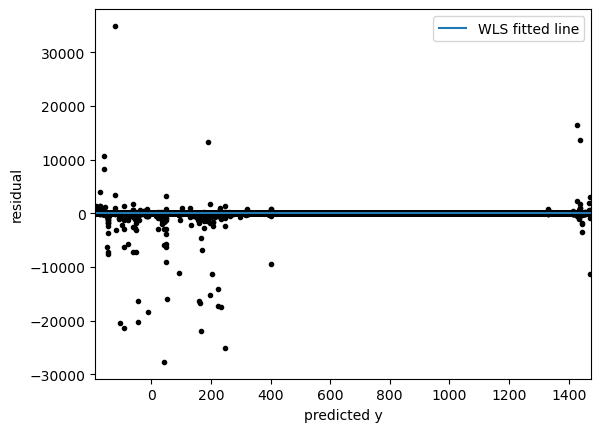

In [22]:
# plot the predicted values, and the residual
plt.scatter(fitted_values2, results2.resid * weights, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="WLS fitted line")

plt.xlim(min(fitted_values2), max(fitted_values2))
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()
plt.show()

very different before without add weight, the resul residual is very better consistent

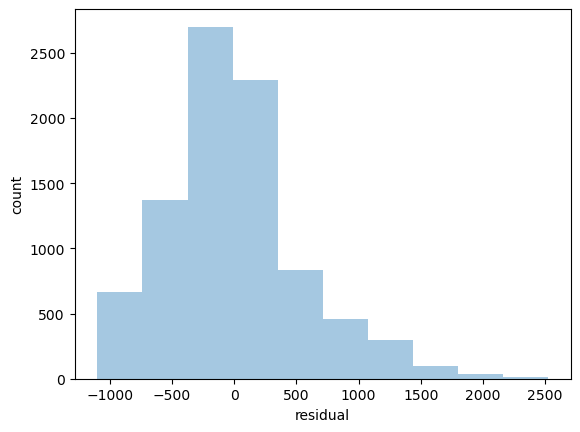

In [23]:
# check normaly error
plt.hist(results2.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

Result:

- Distribution of normaly error is skew 

### Evaluation Model

In [24]:
# check rsquared with weight
results2.rsquared

0.2900448841778287

In [25]:
# check rsme with weight
rsme = mean_squared_error(data_linier_single['Rented_Bike'], y_pred, squared=False)
rsme

543.4363268944784

Result:

- Rsquared from 1 column predictor is very low : 0.29
- Rsme from 1 column predictor is very high : 543.4

# Model Multiple Linier Regression 

We just make two columns for predict because the columns make high correlation
- Temperature (0.54 correlation)
- Seasons (p-value = -0.272)

In [26]:
# Create OLS model object
model = smf.ols("Rented_Bike ~ Temperature + Seasons_Autumn + Seasons_Spring + Seasons_Summer + Seasons_Winter", data_modeling)

# Fit the model
result_1 = model.fit()
y_pred_ = results2.predict(data_modeling[["Temperature", "Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter"]])

# Extract the results (Coefficient and Standard Error) to DataFrame
results_ = print_coef_std_err(result_1)

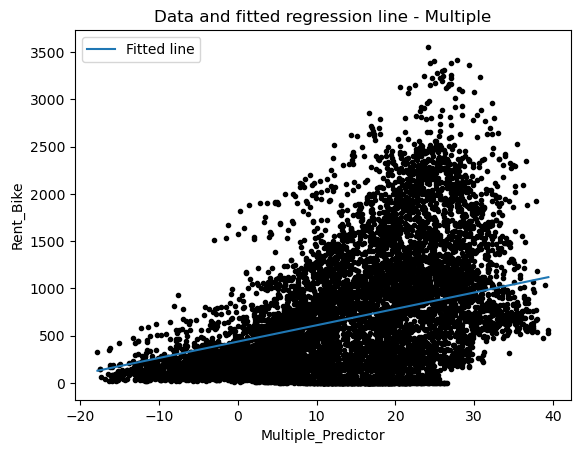

In [27]:
predictors = ["Temperature", "Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter"]
outcome = "Rented_Bike"
data = data_modeling.copy()
results_ = results_.copy()
# linestyles = {0 : "--", 1: "-"}
# c = {0 : "b", 1: "g"}
# markers = {0 : "x", 1: "."}

# Plot the data
plt.scatter(data[predictors[0]], data[outcome], color = "k", marker=".")


# x value predictors value
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), len(data))

# Calculate the fitted values for two lines regarding the mom_hs (0 and 1)
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]
beta3_hat = results_.loc[predictors[2]]["coef"]
beta4_hat = results_.loc[predictors[3]]["coef"]
beta5_hat = results_.loc[predictors[4]]["coef"]

fitted_values_multiple = beta0_hat +  beta1_hat + beta2_hat + beta3_hat + beta4_hat + beta5_hat * x_domain * data[predictors[1]].mean()

# Plot two fitted line
plt.plot(x_domain, fitted_values_multiple, label = f"Fitted line")

# Add a legend and labels
plt.legend()
plt.ylabel(f"Rent_Bike")
plt.xlabel(f"Multiple_Predictor")

# Add a title and adjust the margins
plt.title("Data and fitted regression line - Multiple")

# Show the plot
plt.show()

In [28]:
results_

,coef,std err
Intercept,236.726480,10.848408
Temperature,31.744113,0.958353
Seasons_Autumn,134.618172,10.743483
Seasons_Spring,79.149043,10.390211
Seasons_Summer,-46.500203,18.600423
Seasons_Winter,69.459468,15.892145


$$\text{rent}= 236.726480 + 31.744113(Temperature) + 134.618172(Seasons_Autumn) + 79.149043(Seasons_Spring) -46.500203(Seasons_Summer) + 69.459468 \text{(Seasons_Winter)} $$

- Rent is 236.726480  if all variable '0'
- If Seasons_Spring = 1 then rent bike added 79.149043
- If Seasons_Winter = 1 then rent bike added 69.459468
- If Seasons_Autumn = 1 then rent bike added 134.618172
- If Seasons_Summer = 1 then rent bike deducted -46.500203
- If temperature contain value, then times value with 31.744113 and the add with intercept rent_bike

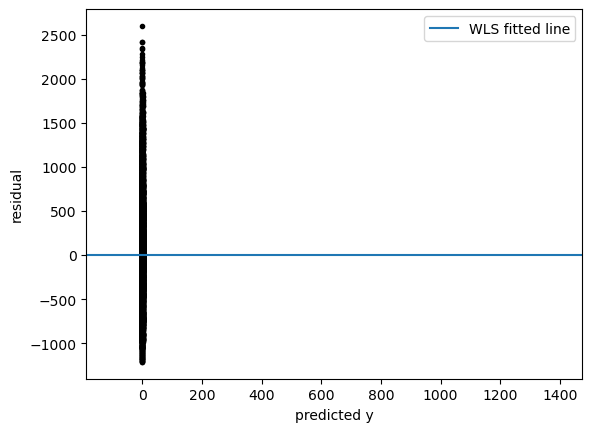

In [66]:
# plot the predicted values, and the residual
plt.scatter(fitted_values_multiple, result_1.resid, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="WLS fitted line")

plt.xlim(min(fitted_values2), max(fitted_values2))
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()
plt.show()

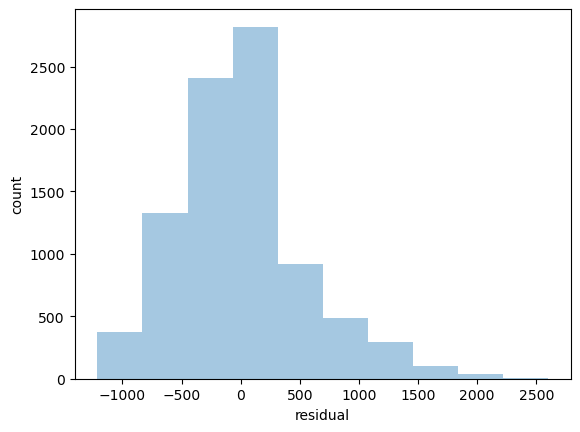

In [29]:
# check normaly error
plt.hist(result_1.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

In [30]:
# check Rsquare
result_1.rsquared

0.2980950002245881

In [31]:
# check rsme 
rsme = mean_squared_error(data_modeling['Rented_Bike'], y_pred_, squared=False)
rsme

543.4363268944784

Result:

- Rsquared from multiple column predictor is very low : 0.29
- Rsme from multiple column predictor is very high : 543.4

is the same with single column 

### Transformation

In [32]:
def normalizer(data):
    """
    This function used for convert data to
    Normal scaler
    """
    # make scaler
    normal = Normalizer()

    # normalize the data (fit)
    normalized_data = normal.fit_transform(data)
    normalized_data = pd.DataFrame(normalized_data,
                           index = data.index,
                           columns = data.columns)

    return normalized_data, normal

### Single Predictor Model 

In [33]:
# call function transform 
data_normalizer, scaler = normalizer(data = data_modeling[['Temperature','Rented_Bike']])

In [34]:
# Create OLS model object
model = smf.ols("Rented_Bike ~ Temperature", data_normalizer)

# Fit the model
results_normalize = model.fit()
y_pred_normalize = results_normalize.predict(data_normalizer['Temperature'])

# Extract the results (Coefficient and Standard Error) to DataFrame
results_rent_normal = print_coef_std_err(results_normalize)

In [35]:
results_rent_normal

,coef,std err
Intercept,1.011656,0.000801
Temperature,-0.825444,0.003715


$$\text{rent}= 1.011656 + -0.825444\text{(Temperature)} $$

- If Temperature is zero then rent bike is 1.011656, otherwise follow the value input that given from count temperature

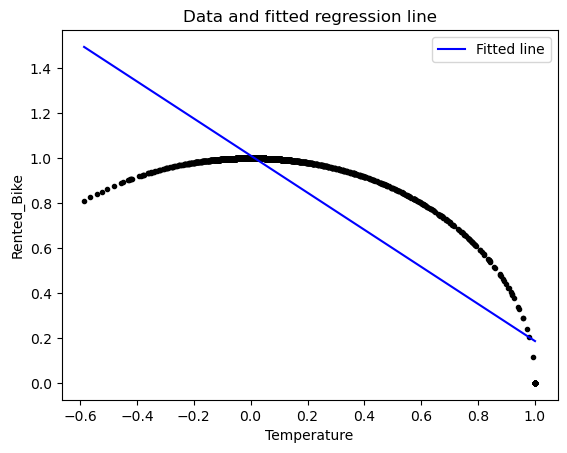

In [36]:
predictor = "Temperature"
outcome = "Rented_Bike"
data = data_normalizer.copy()
results_ = results_rent_normal.copy()

# Plot the data
plt.scatter(data[predictor], data[outcome], color = "k", marker=".")

# Calculate the fitted values
a_hat = results_.loc["Intercept"]["coef"]
b_hat = results_.loc[predictor]["coef"]

x_domain = np.linspace(np.min(data[predictor]), np.max(data[predictor]), len(data))

fitted_values_trans = a_hat + b_hat * x_domain

# Plot the fitted line
plt.plot(x_domain, fitted_values_trans, label="Fitted line", color = "b")

# Add a legend and labels
plt.legend()
plt.ylabel("Rented_Bike")
plt.xlabel("Temperature")

# Add a title and adjust the margins
plt.title("Data and fitted regression line")

# Show the plot
plt.show()

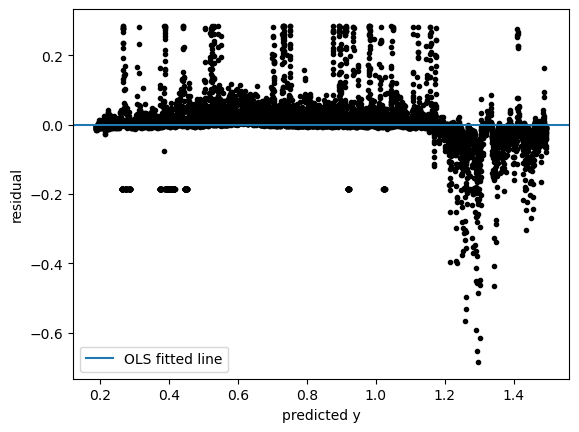

In [37]:
# plot the predicted values, and the residual
plt.scatter(fitted_values_trans, results_normalize.resid, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="OLS fitted line")
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()

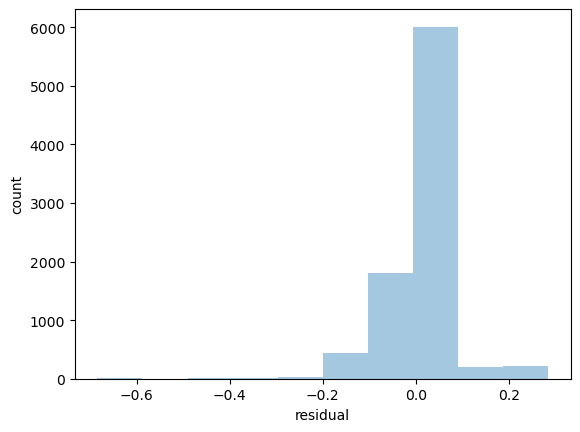

In [38]:
# check normaly error
plt.hist(results_normalize.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

In [39]:
# check Rsquare with 
results_normalize.rsquared

0.8493138352332285

In [40]:
# check rsme 
rsme_ = mean_squared_error(data_normalizer['Rented_Bike'], y_pred_normalize, squared=False)
rsme_

0.07159913422628561

Result:

- After we done make transformation with normalize method, normal error almost perfect
- Rsquared from single column predictor is very high : 0.84
- Rsme from single column predictor is very low : 0.071

### Multiple Predictor Model 

In [41]:
# split data columns for modeling
season_col = data_modeling [["Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter"]]

In [42]:
# concat with data transform
data_multiple_con = pd.concat([data_normalizer, season_col],
                           axis = 1)

(data_multiple_con.shape)

(8760, 6)

In [43]:
# Create OLS model object
model = smf.ols("Rented_Bike ~ Temperature + Seasons_Autumn + Seasons_Spring + Seasons_Summer + Seasons_Winter", data_multiple_con)

# Fit the model
result_norm = model.fit()
y_pred_norm = result_norm.predict(data_multiple_con[["Temperature", "Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter"]])

# Extract the results (Coefficient and Standard Error) to DataFrame
results_norm_ = print_coef_std_err(result_norm)

In [44]:
results_norm_

,coef,std err
Intercept,0.810077,0.000596
Temperature,-0.843997,0.003608
Seasons_Autumn,0.193949,0.001284
Seasons_Spring,0.223056,0.001237
Seasons_Summer,0.231128,0.001233
Seasons_Winter,0.161944,0.001276


$$\text{rent}= 0.810077 - 0.843997(Temperature) + 0.193949(Seasons_Autumn) + 0.223056(Seasons_Spring) 0.231128(Seasons_Summer) + 0.161944 \text{(Seasons_Winter)} $$

- Rent is 0.810077  if all variable '0'
- If Seasons_Spring = 1 then rent bike added - 0.843997
- If Seasons_Winter = 1 then rent bike added 0.193949
- If Seasons_Autumn = 1 then rent bike added 0.223056
- If Seasons_Summer = 1 then rent bike deducted 0.161944
- If temperature contain value, then times value with - 0.843997and the add with intercept rent_bike

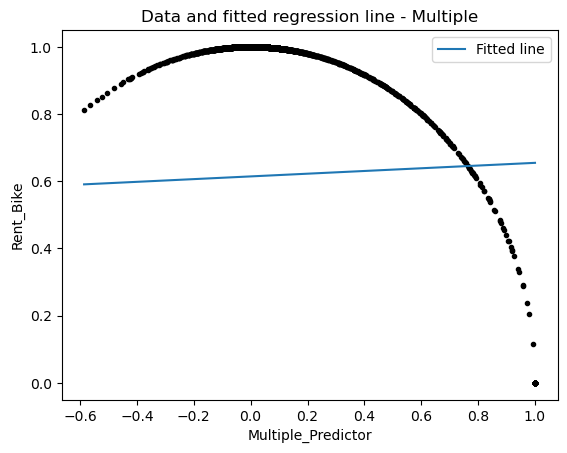

In [45]:
predictors = ["Temperature", "Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter"]
outcome = "Rented_Bike"
data = data_multiple_con.copy()
results_ = results_norm_.copy()
# linestyles = {0 : "--", 1: "-"}
# c = {0 : "b", 1: "g"}
# markers = {0 : "x", 1: "."}

# Plot the data
plt.scatter(data[predictors[0]], data[outcome], color = "k", marker=".")


# x value predictors value
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), len(data))

# Calculate the fitted values for two lines regarding the mom_hs (0 and 1)
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]
beta3_hat = results_.loc[predictors[2]]["coef"]
beta4_hat = results_.loc[predictors[3]]["coef"]
beta5_hat = results_.loc[predictors[4]]["coef"]

fitted_values_multiple = beta0_hat +  beta1_hat + beta2_hat + beta3_hat + beta4_hat + beta5_hat * x_domain * data[predictors[1]].mean()

# Plot two fitted line
plt.plot(x_domain, fitted_values_multiple, label = f"Fitted line")

# Add a legend and labels
plt.legend()
plt.ylabel(f"Rent_Bike")
plt.xlabel(f"Multiple_Predictor")

# Add a title and adjust the margins
plt.title("Data and fitted regression line - Multiple")

# Show the plot
plt.show()

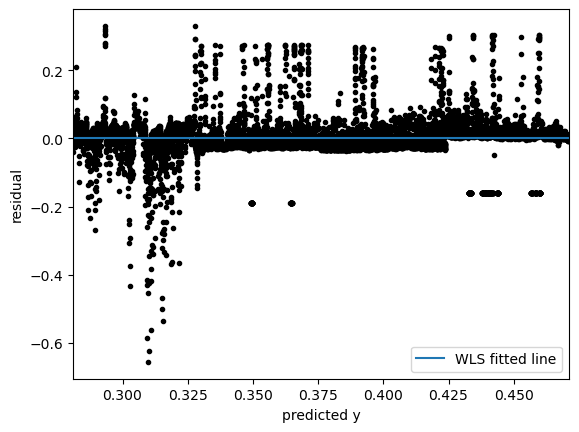

In [71]:
# plot the predicted values, and the residual
plt.scatter(fitted_values_multiple, result_norm.resid, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="WLS fitted line")

plt.xlim(min(fitted_values_multiple), max(fitted_values_multiple))
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()
plt.show()

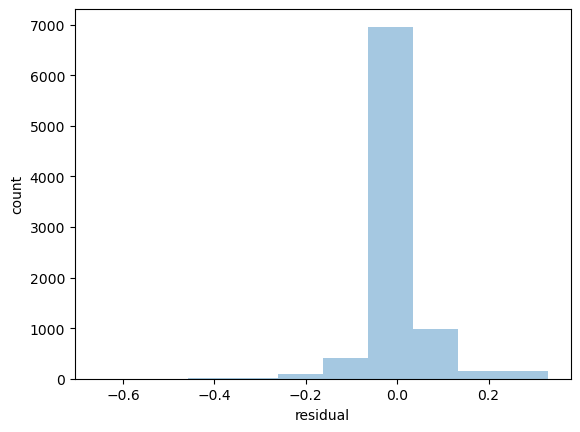

In [46]:
# check normaly error
plt.hist(result_norm.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

In [47]:
# check Rsquare with 
result_norm.rsquared

0.8705420413343773

In [48]:
# check rsme 
rsme_ = mean_squared_error(data_multiple_con['Rented_Bike'], y_pred_norm, squared=False)
rsme_

0.06636444372991242

Result:

- After we done make transformation with normalize method, normal error almost perfect
- Rsquared from multiple column predictor is very high : 0.87
- Rsme from multiple column predictor is very low : 0.066

### Multiple Columns_2 Model

We want add columnt Dew_point_temp because have high correlation with Temperature as big as 0.91

In [49]:
# call function transform 
data_normalizer_2, scaler = normalizer(data = data_modeling[['Temperature','Rented_Bike','Dew_point_temp']])

In [50]:
# concat with data transform
data_multiple_con2 = pd.concat([data_normalizer_2, season_col],
                           axis = 1)

(data_multiple_con2.shape)

(8760, 7)

In [51]:
data_multiple_con2

,Temperature,Rented_Bike,Dew_point_temp,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter
0,-0.020419,0.997400,-0.069111,0,0,0,1
1,-0.026851,0.995940,-0.085924,0,0,0,1
2,-0.034481,0.994215,-0.101720,0,0,0,1
3,-0.057082,0.985132,-0.162040,0,0,0,1
4,-0.074616,0.970014,-0.231311,0,0,0,1
...,...,...,...,...,...,...,...
8755,0.004187,0.999939,-0.010269,1,0,0,0
8756,0.004450,0.999906,-0.012957,1,0,0,0
8757,0.003746,0.999891,-0.014264,1,0,0,0
8758,0.002949,0.999901,-0.013763,1,0,0,0


In [52]:
# Create OLS model object
model = smf.ols("Rented_Bike ~ Temperature + Seasons_Autumn + Seasons_Spring + Seasons_Summer + Seasons_Winter + Dew_point_temp", data_multiple_con2)

# Fit the model
result_norm_2 = model.fit()
y_pred_norm_2 = result_norm_2.predict(data_multiple_con2[["Temperature", "Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter", "Dew_point_temp"]])

# Extract the results (Coefficient and Standard Error) to DataFrame
results_norm_2 = print_coef_std_err(result_norm_2)

In [53]:
results_norm_2

,coef,std err
Intercept,0.816741,0.000547
Temperature,-1.296807,0.006486
Seasons_Autumn,0.196308,0.001134
Seasons_Spring,0.218329,0.001097
Seasons_Summer,0.218664,0.001118
Seasons_Winter,0.183441,0.001256
Dew_point_temp,0.539591,0.009097


$$\text{rent}= 0.816741 - 1.296807(Temperature) + 0.193949(Seasons_Autumn) + 0.218329(Seasons_Spring) + 0.218664(Seasons_Summer) + 0.183441(Seasons_Winter) + 0.539591\text{(Dew_point_temp)} $$

- Rent_bike is 0.816741  if all variable '0'
- If Seasons_Spring = 1 then rent bike added 0.196308	
- If Seasons_Winter = 1 then rent bike added 0.218329
- If Seasons_Autumn = 1 then rent bike added 0.218664
- If Seasons_Summer = 1 then rent bike added 0.183441
- If temperature and Dew_point_temp contain value, then times value with -1.296807 / 0.539591 and the add with intercept rent_bike

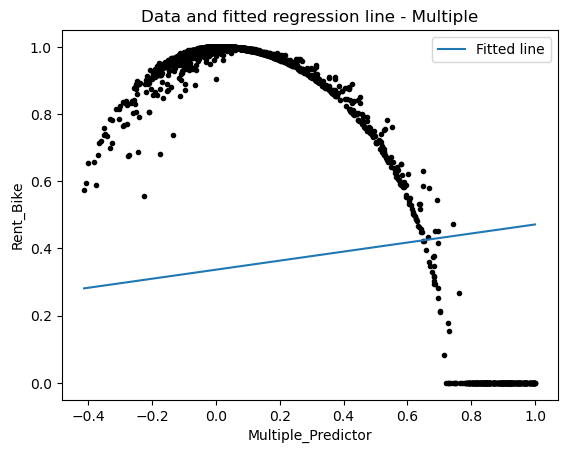

In [68]:
predictors = ["Temperature", "Seasons_Autumn", "Seasons_Spring", "Seasons_Summer", "Seasons_Winter", "Dew_point_temp"]
outcome = "Rented_Bike"
data = data_multiple_con2.copy()
results_ = results_norm_2.copy()
# linestyles = {0 : "--", 1: "-"}
# c = {0 : "b", 1: "g"}
# markers = {0 : "x", 1: "."}

# Plot the data
plt.scatter(data[predictors[0]], data[outcome], color = "k", marker=".")


# x value predictors value
x_domain = np.linspace(np.min(data[predictors[0]]), np.max(data[predictors[0]]), len(data))

# Calculate the fitted values for two lines regarding the mom_hs (0 and 1)
beta0_hat = results_.loc["Intercept"]["coef"]
beta1_hat = results_.loc[predictors[0]]["coef"]
beta2_hat = results_.loc[predictors[1]]["coef"]
beta3_hat = results_.loc[predictors[2]]["coef"]
beta4_hat = results_.loc[predictors[3]]["coef"]
beta5_hat = results_.loc[predictors[4]]["coef"]
beta6_hat = results_.loc[predictors[5]]["coef"]

fitted_values_multiple_ = beta0_hat +  beta1_hat + beta2_hat + beta3_hat + beta4_hat + beta5_hat + beta6_hat * x_domain * data[predictors[1]].mean()

# Plot two fitted line
plt.plot(x_domain, fitted_values_multiple_, label = f"Fitted line")

# Add a legend and labels
plt.legend()
plt.ylabel(f"Rent_Bike")
plt.xlabel(f"Multiple_Predictor")

# Add a title and adjust the margins
plt.title("Data and fitted regression line - Multiple")

# Show the plot
plt.show()

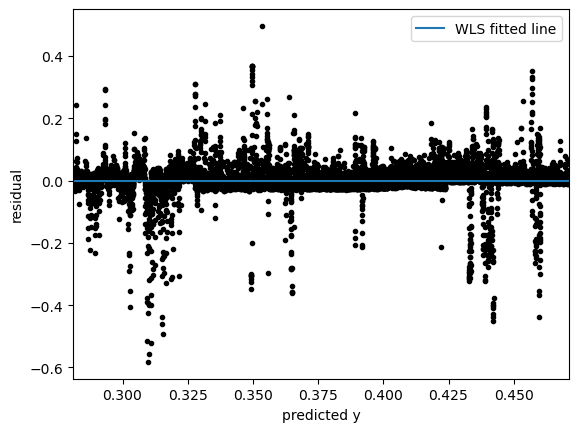

In [70]:
# plot the predicted values, and the residual
plt.scatter(fitted_values_multiple_, result_norm_2.resid, 
            marker = ".", 
            color = "k")

# Plot the fitted line as horizontal line at zero
plt.axhline(0, label="WLS fitted line")

plt.xlim(min(fitted_values_multiple_), max(fitted_values_multiple_))
plt.ylabel("residual")
plt.xlabel("predicted y")
plt.legend()
plt.show()

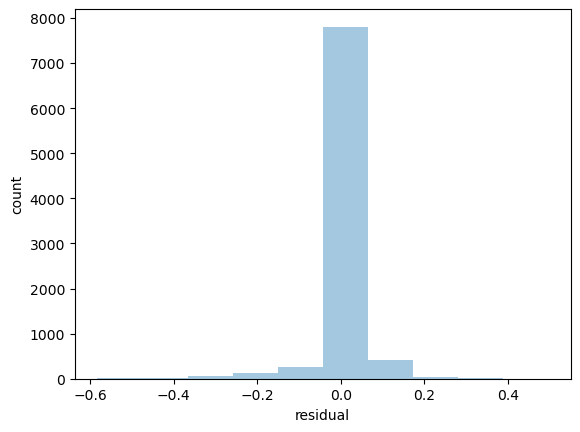

In [55]:
# check normaly error
plt.hist(result_norm_2.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

In [56]:
# check Rsquare with 
result_norm_2.rsquared

0.9027724598842554

In [57]:
# check rsme 
rsme_ = mean_squared_error(data_multiple_con2['Rented_Bike'], y_pred_norm_2, squared=False)
rsme_

0.05854512036425197

### Cross Validation

In [58]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

### Single Column Model 

In [59]:
# call function bestestimator
regress_single =StatsmodelsRegressor(smf.ols, "Rented_Bike ~ Temperature")

In [60]:
# Create k-fold splitter object
kfold = KFold(n_splits=10, shuffle = True, random_state=123)

In [61]:
# crossvalidation single column
scores_ols_single = cross_val_score(estimator = regress_single,
                                    X = data_normalizer,
                                    y = data_normalizer["Rented_Bike"],
                                    cv = kfold,
                                    scoring = "r2")
scores_ols_single = pd.DataFrame(data = scores_ols_single, columns=["test_rsquared"])
scores_ols_single["folds"] = [f"Folds {i+1}" for i in range(10)]
scores_ols_single["test_rsquared"].mean()

0.846427169375399

### Multiple Column Model

In [62]:
# call function bestestimator
regress_multiple =StatsmodelsRegressor(smf.ols, "Rented_Bike ~ Temperature + Seasons_Autumn + Seasons_Spring + Seasons_Summer + Seasons_Winter")

In [63]:
# crossvalidation multiple column
scores_ols_single = cross_val_score(estimator = regress_multiple,
                                    X = data_multiple_con,
                                    y = data_multiple_con["Rented_Bike"],
                                    cv = kfold,
                                    scoring = "r2")
scores_ols_single = pd.DataFrame(data = scores_ols_single, columns=["test_rsquared"])
scores_ols_single["folds"] = [f"Folds {i+1}" for i in range(10)]
scores_ols_single["test_rsquared"].mean()

0.8679665949287122

In [64]:
# call function bestestimator add column Dew_point_temp
regress_multiple2 =StatsmodelsRegressor(smf.ols, "Rented_Bike ~ Temperature + Seasons_Autumn + Seasons_Spring + Seasons_Summer + Seasons_Winter + Dew_point_temp")

In [65]:
# crossvalidation multiple column and add column Dew_point_temp
scores_ols_single = cross_val_score(estimator = regress_multiple2,
                                    X = data_multiple_con2,
                                    y = data_multiple_con2["Rented_Bike"],
                                    cv = kfold,
                                    scoring = "r2")
scores_ols_single = pd.DataFrame(data = scores_ols_single, columns=["test_rsquared"])
scores_ols_single["folds"] = [f"Folds {i+1}" for i in range(10)]
scores_ols_single["test_rsquared"].mean()

0.9009805543154353